In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [2]:

def calculate_P_E(data):
    attributes = [
        "pleasant",
        "eventful",
        "chaotic",
        "vibrant",
        "uneventful",
        "calm",
        "annoying",
        "monotonous",
    ]  # Define attributes to extract from dataframes
    ISOPl_weights = [
        1,
        0,
        -np.sqrt(2) / 2,
        np.sqrt(2) / 2,
        0,
        np.sqrt(2) / 2,
        -1,
        -np.sqrt(2) / 2,
    ]  # Define weights for each attribute in attributes in computation of ISO Pleasantness
    ISOEv_weights = [
        0,
        1,
        np.sqrt(2) / 2,
        np.sqrt(2) / 2,
        -1,
        -np.sqrt(2) / 2,
        0,
        -np.sqrt(2) / 2,
    ]  # Define weights for each attribute in attributes in computation of ISO Eventfulness
    P = np.mean(
        ((data[attributes] * ISOPl_weights).sum() / (4 + np.sqrt(32)))
    )  # These are normalised ISO Pleasantness values (in [-1,1])
    E = np.mean(
        ((data[attributes] * ISOEv_weights).sum() / (4 + np.sqrt(32)))
    )  # These are normalised ISO Eventfulness values (in [-1,1])
    return pd.Series({"P": P, "E": E})



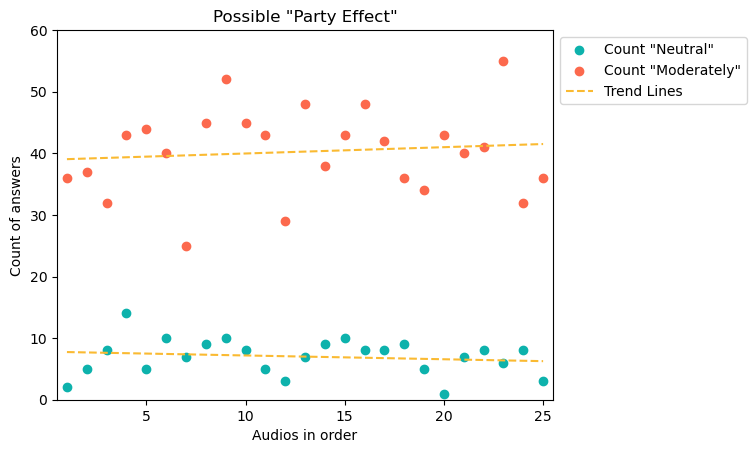

In [3]:
# Read the csv file into a DataFrame
df = pd.read_csv("../data/main_files/all_answers_listening_tests.csv", delimiter=";")

# Separate data into two sub-dataframes
general_df = pd.DataFrame(df[["order","overall"]])
reduced_general_df= pd.DataFrame(df["overall"])
emotions_df= pd.DataFrame(df[["order","pleasant","chaotic","vibrant","uneventful","calm","annoying","eventful","monotonous"]])
reduced_emotions_df= pd.DataFrame(df[["pleasant","chaotic","vibrant","uneventful","calm","annoying","eventful","monotonous"]])

# Count the number of occurrences of 3 in each row and store the result in a new column
general_df["count_of_3s"] = (reduced_general_df == 3).sum(axis=1)
emotions_df["count_of_3s"] = (reduced_emotions_df == 3).sum(axis=1)


# Group by the first column and sum the values in the second column for each group
general_df = general_df.groupby(general_df.iloc[:, 0]).sum()["count_of_3s"]
emotions_df = emotions_df.groupby(emotions_df.iloc[:, 0]).sum()["count_of_3s"]


# Calculate the trend line
x = np.arange(1,26,1)
y_general = general_df.values
slope, intercept, _, _, _ = linregress(x, y_general)
trend_line_general = slope * x + intercept
y_emotions = emotions_df.values
slope, intercept, _, _, _ = linregress(x, y_emotions)
trend_line_emotions = slope * x + intercept

# Display
plt.scatter(x,general_df.values, label='Count "Neutral"', color="#0db2ac")
plt.scatter(x,emotions_df.values, label='Count "Moderately"', color="#fc694d")
plt.plot(x, trend_line_general, color='#faba32', linestyle='--',label='Trend Lines')
plt.plot(x, trend_line_emotions, color='#faba32',linestyle='--')

# Add labels and legend
plt.xlabel('Audios in order')
plt.ylabel('Count of answers')
plt.xlim(0.5,25.5)
plt.ylim(0,60)
plt.title('Possible "Party Effect"')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.rcParams['font.family'] = 'sans-serif'
# Show plot
plt.show()


In [4]:
palette = {
    "traffic": "#FC694D",
    "construction": "#FABA32",
    "human": "#0DB2AC",
    "natural": "#84B66F"
}

# Read the csv file into a DataFrame
df = pd.read_csv("../data/main_files/all_answers_listening_tests.csv", delimiter=";")

# Apply the function to each row of the DataFrame
df[["P", "E"]] = df.apply(calculate_P_E, axis=1)

df_sources=pd.DataFrame(df[["file", "traffic", "construction", "human", "natural","pleasant","chaotic","vibrant","uneventful","calm","annoying","eventful","monotonous", "P", "E"]])
# Group by the 'file' column and calculate the mean for the other columns
grouped_df = df_sources.groupby("file").mean().reset_index()


# Find the column name with the maximum value for each row
grouped_df['Predominant sources'] = grouped_df[["traffic", "construction", "human", "natural"]].idxmax(axis=1)
df['Predominant sources'] = df[["traffic", "construction", "human", "natural"]].idxmax(axis=1)



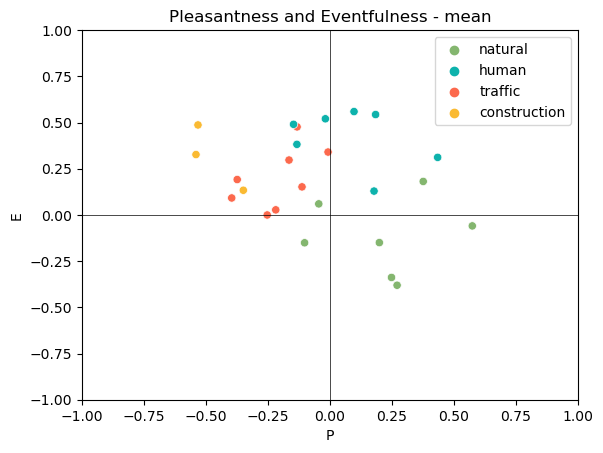

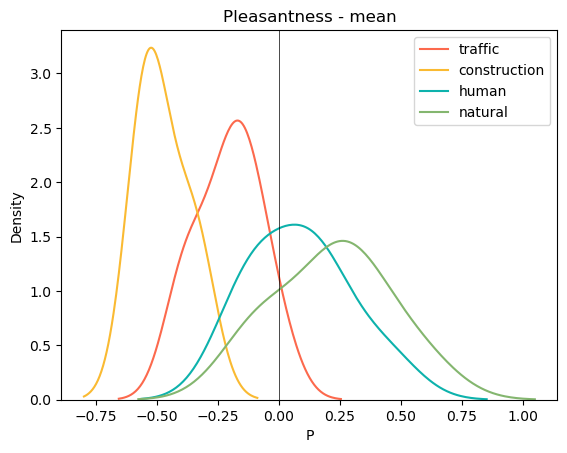

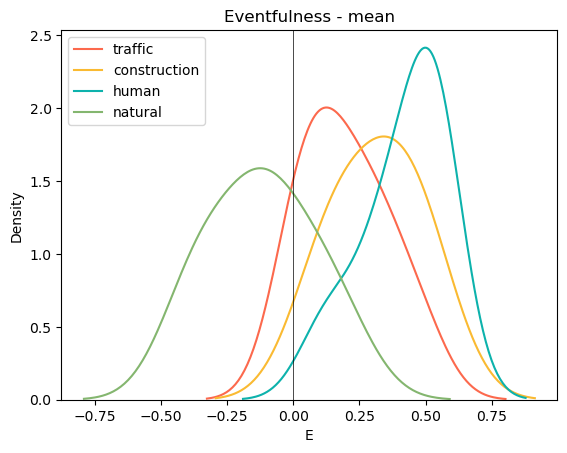

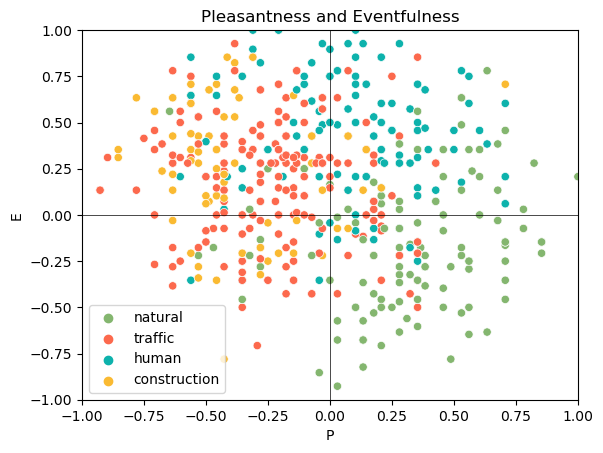

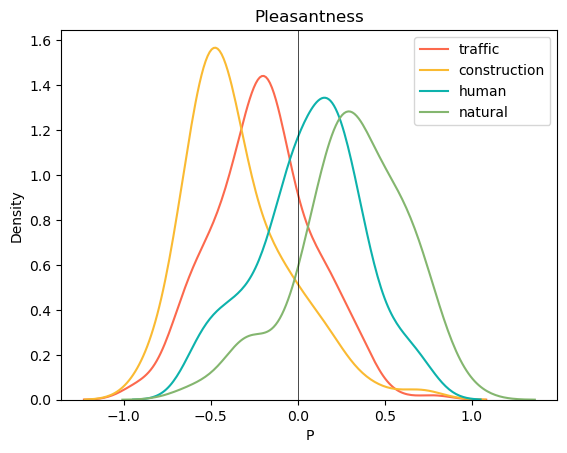

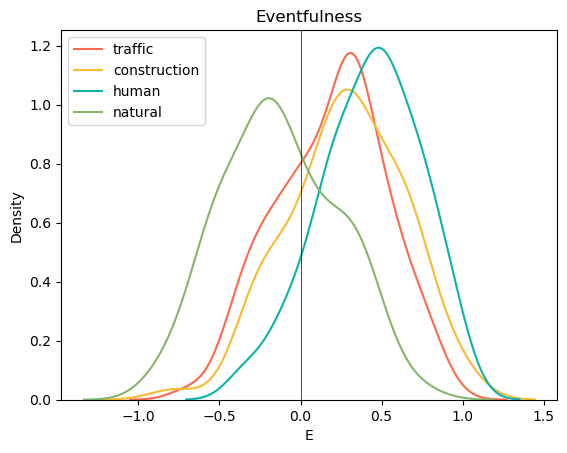

In [5]:


# Scatter plot with different colors for each series
sns.scatterplot(data=grouped_df, x="P", y="E", hue="Predominant sources", palette=palette)
plt.rcParams['font.family'] = 'sans-serif'
# Center the axis lines at zero
plt.xlim(-1, 1)
plt.ylim(-1, 1)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Pleasantness and Eventfulness - mean")
# Show legend
plt.legend()
plt.show()

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source]["P"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Pleasantness - mean")
# Show legend
plt.legend()
plt.show()

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source]["E"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Eventfulness - mean")
# Show legend
plt.legend()
plt.show()


# Scatter plot with different colors for each series
sns.scatterplot(data=df, x="P", y="E", hue="Predominant sources", palette=palette)
plt.rcParams['font.family'] = 'sans-serif'
# Center the axis lines at zero
plt.xlim(-1, 1)
plt.ylim(-1, 1)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Pleasantness and Eventfulness")
# Show legend
plt.legend()
plt.show()

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(df[df["Predominant sources"] == source]["P"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Pleasantness")
# Show legend
plt.legend()
plt.show()

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(df[df["Predominant sources"] == source]["E"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Eventfulness")
# Show legend
plt.legend()
plt.show()


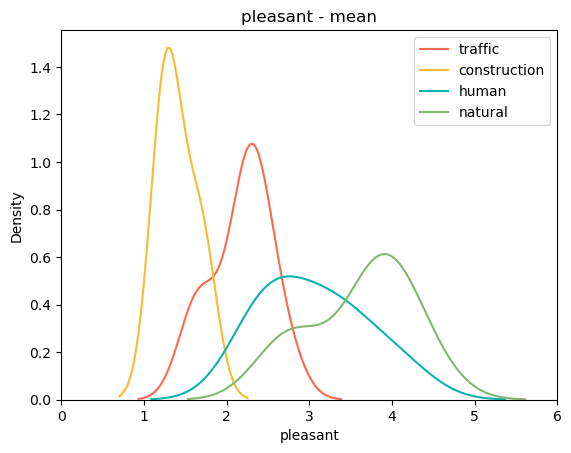

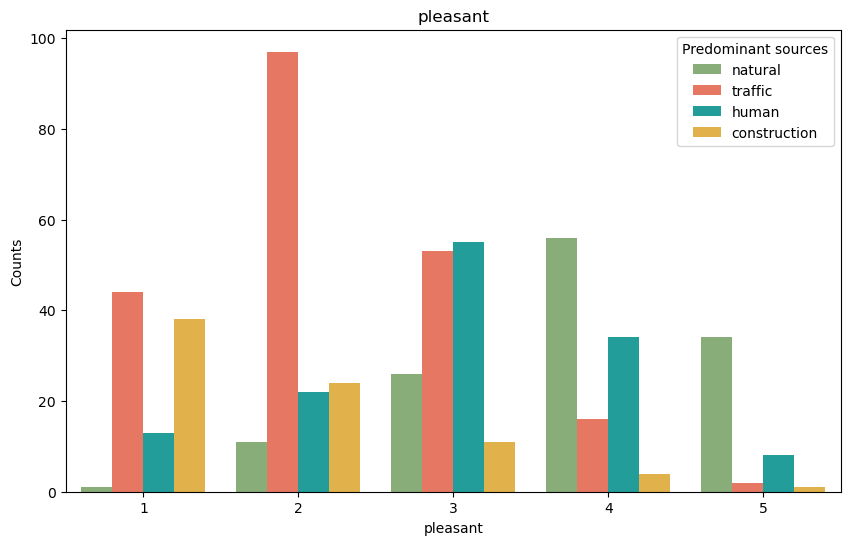

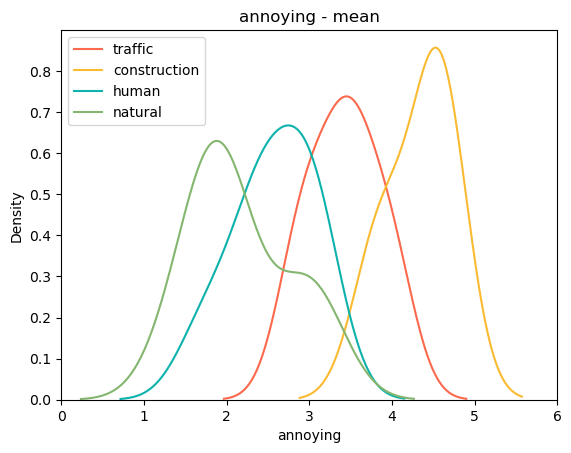

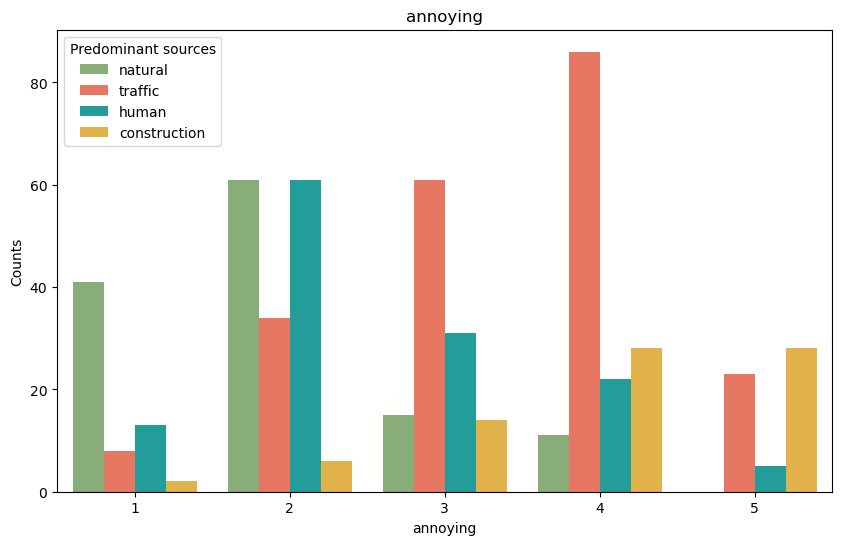

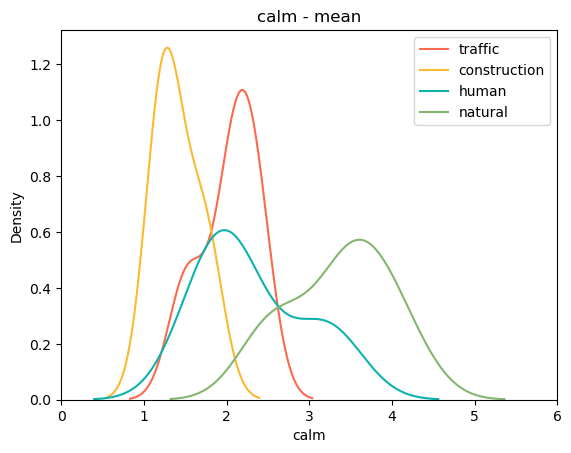

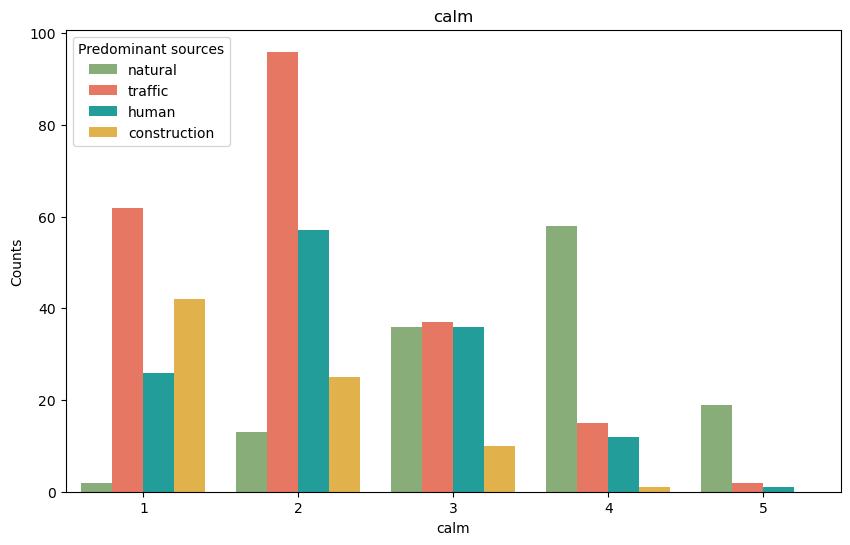

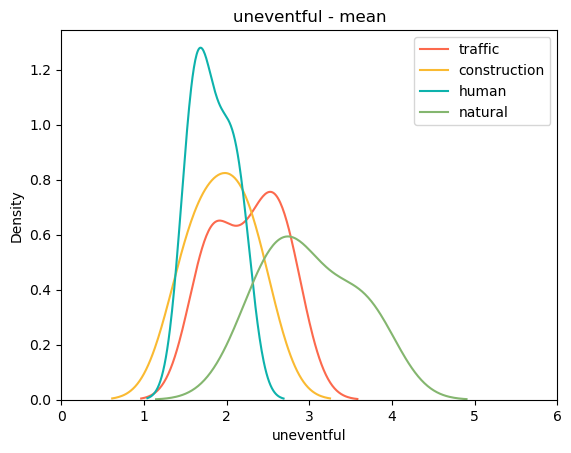

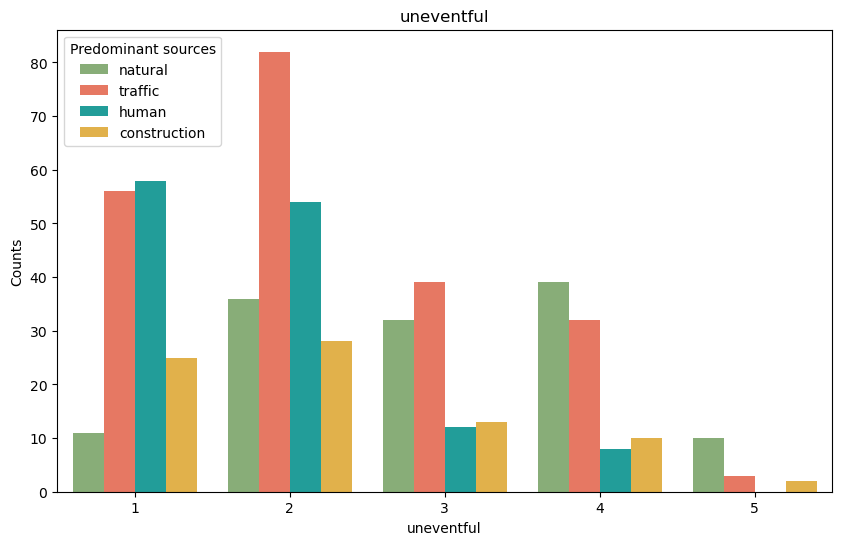

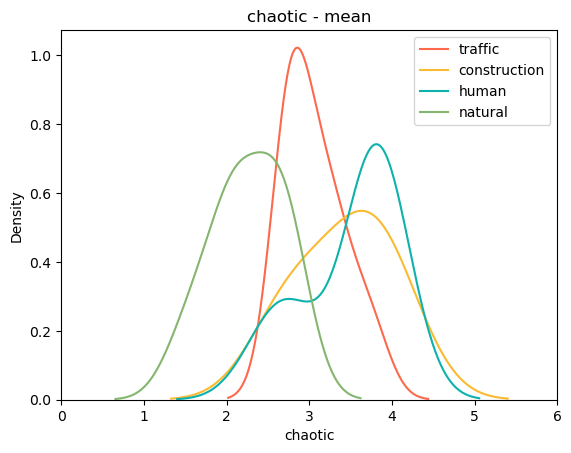

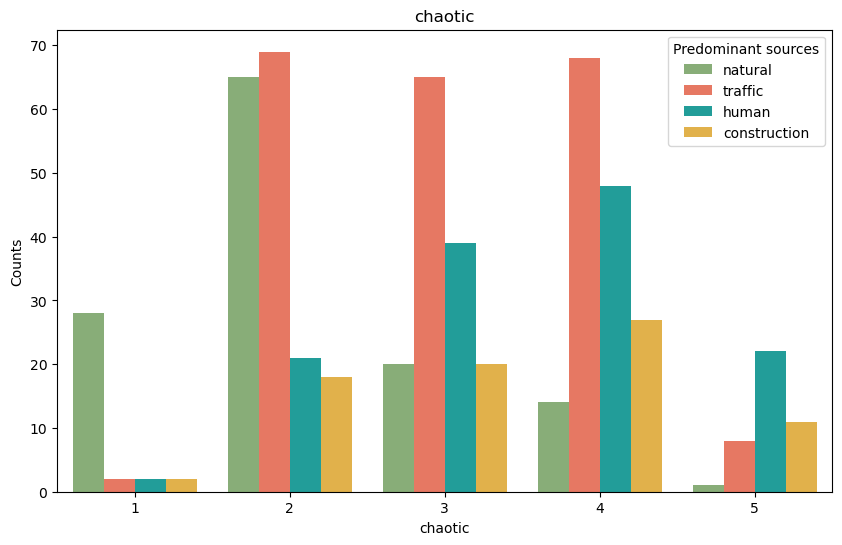

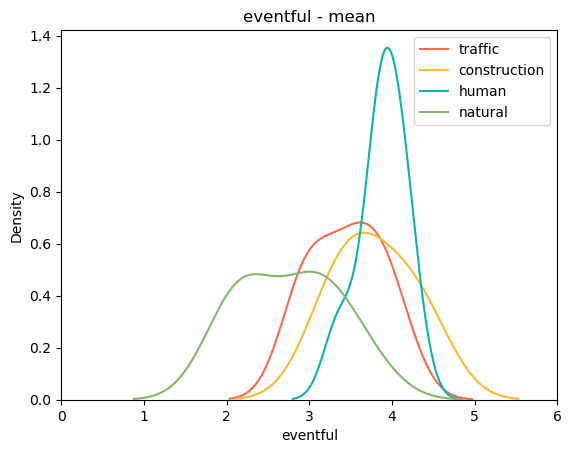

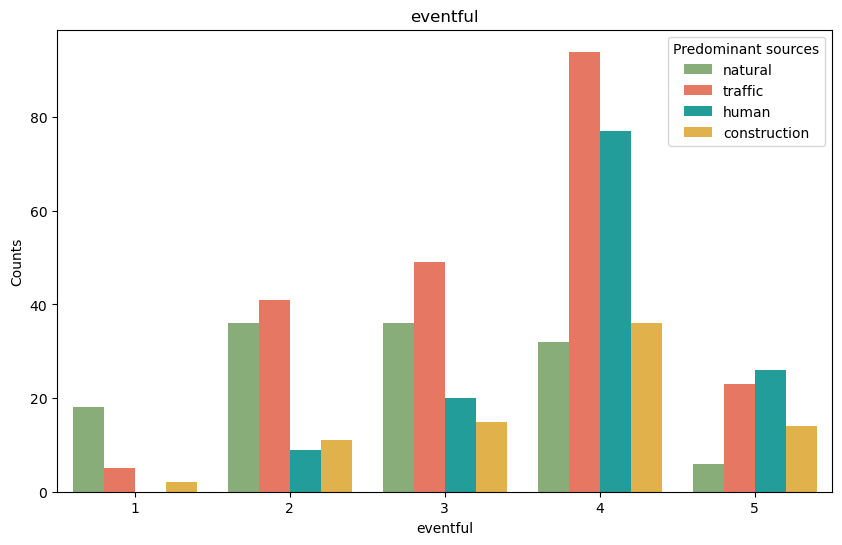

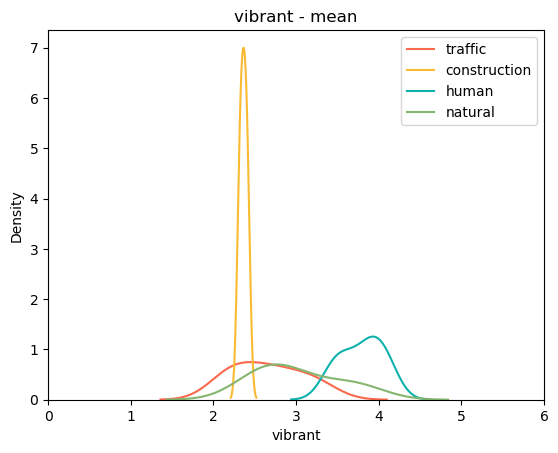

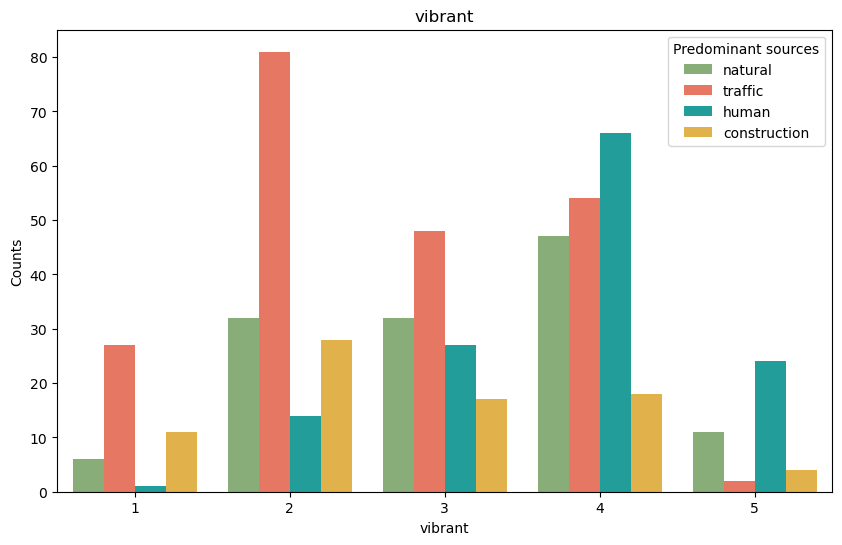

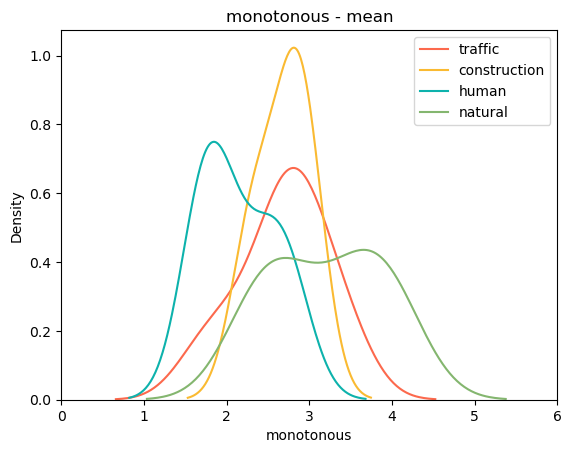

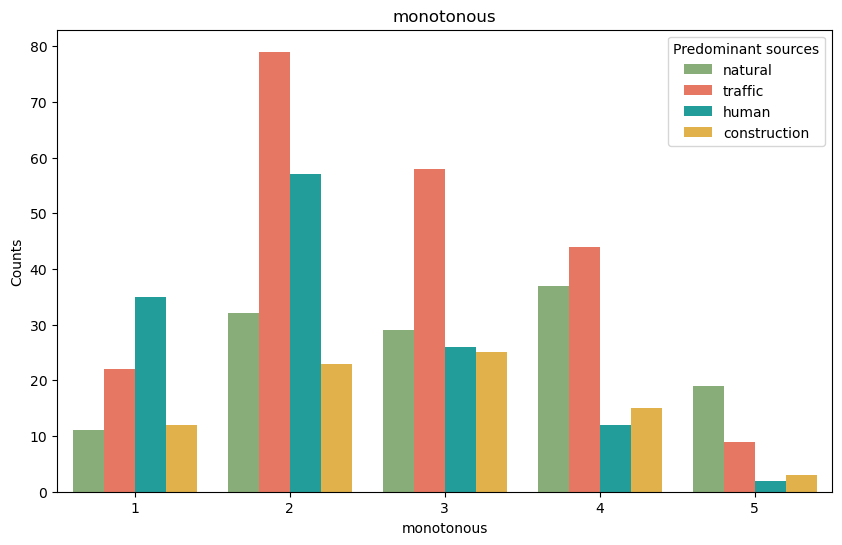

In [6]:
values={"calm", "vibrant", "pleasant", "eventful", "chaotic", "monotonous", "annoying", "uneventful"}

for value in values:
    # KDE plots with different colors and series names
    for source, color in palette.items():
        sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source][value], label=source, color=color)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    title=value+" - mean"
    plt.title(title)
    plt.xlim([0,6])
    # Show legend
    plt.legend()
    plt.show()
    # Create a count plot for each source
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=value, hue="Predominant sources", palette=palette, dodge=True)
    # Show legend
    plt.legend(title='Predominant sources')
    plt.xlabel(value)
    plt.ylabel('Counts')
    plt.title(value)
    plt.show()



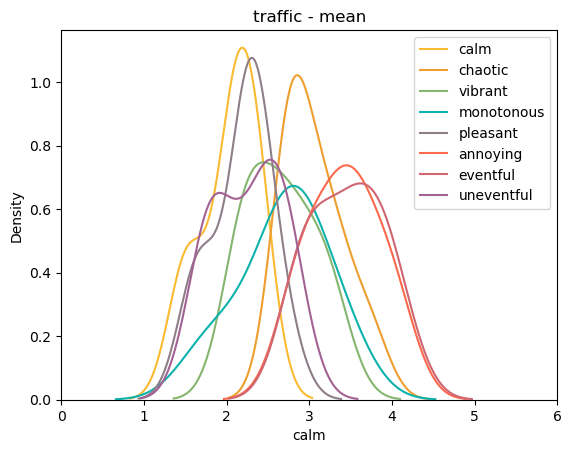

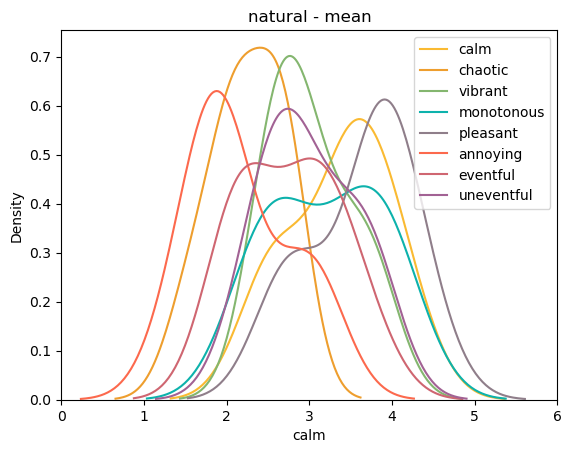

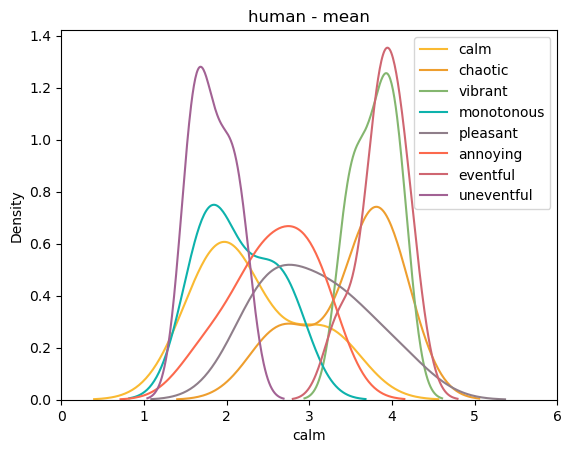

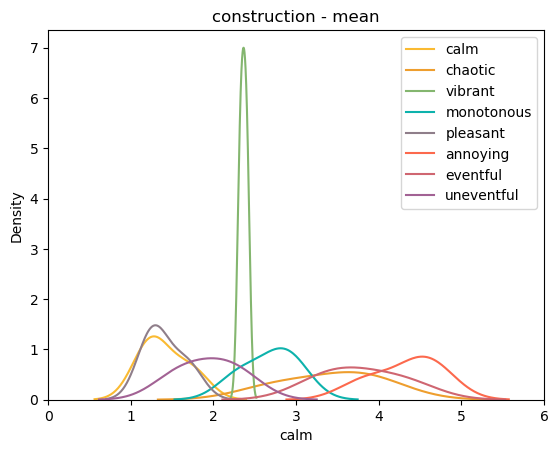

In [7]:
values_palette={"calm":"#FABA32","chaotic":"#EE9E2E", "vibrant":"#84B66F","monotonous":"#0DB2AC", "pleasant":"#8F7E8A","annoying":"#FC694D", "eventful":"#CF6671",   "uneventful":"#A26294"}
sources={
    "traffic",
    "construction",
    "human",
    "natural"
}
for source in sources:
    # KDE plots with different colors and series names
    for value, color in values_palette.items():
        sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source][value], label=value, color=color)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    title=source+" - mean"
    plt.title(title)
    plt.xlim([0,6])
    # Show legend
    plt.legend()
    plt.show()

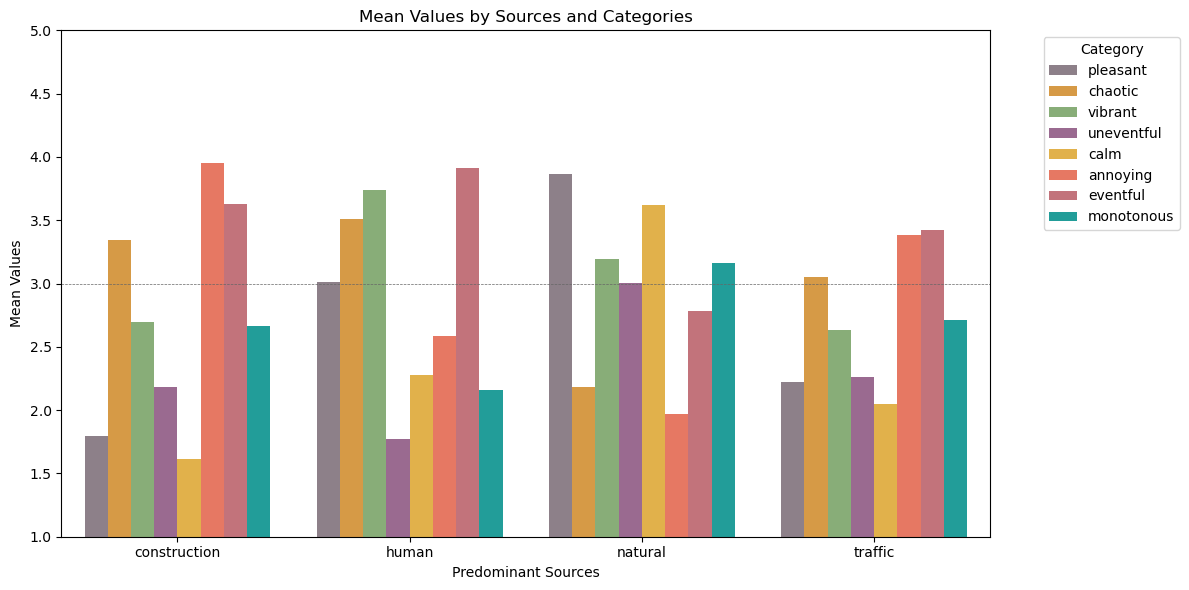

In [8]:
categories={"calm", "vibrant", "pleasant", "eventful", "chaotic", "monotonous", "annoying", "uneventful", "Predominant sources"}
# Group by 'Predominant sources' and sum the other columns
# Group by 'Predominant sources' and compute the mean
grouped_df = df.groupby("Predominant sources").mean().reset_index()

# Convert the DataFrame to long format
df_long = grouped_df.melt(id_vars=["Predominant sources"], 
                  value_vars=["pleasant", "chaotic", "vibrant", "uneventful", "calm", "annoying", "eventful", "monotonous"],
                  var_name="Category", value_name="Value")

# Set the figure size
plt.figure(figsize=(12, 6))
# Create the bar plot
sns.barplot(data=df_long, x="Predominant sources", y="Value", hue="Category", dodge=True, palette=values_palette)
plt.ylim(1, 5)
# Add legend
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot title and labels
plt.title("Mean Values by Sources and Categories")
plt.xlabel("Predominant Sources")
plt.ylabel("Mean Values")



plt.axhline(3, color='#666666',linestyle='--',linewidth=0.5)
# Show plot
plt.tight_layout()
plt.show()
